# Overcast CRE vs. cloud type as vertically stacked plots (only set 2 and lower clouds)

We plot the overcast CRE vs. cloud type. Overcast CRE means that each cloud type radiative effects is calculated for a hypothetical situation of 100% cloud cover for this type.

## Load Standard and User Libraries

In [1]:
%matplotlib inline

import os, sys, copy, glob
import numpy as np
import datetime
import seaborn as sns
import pylab as pl

In [2]:
pl.rcParams['figure.figsize'] = (16.0, 8.0)
pl.rcParams['font.size'] = 18.0
pl.rcParams['lines.linewidth'] = 3
import xarray as xr

In [3]:
import nawdex_analysis.analysis.ave_cre
import nawdex_analysis.io.collector

import nawdex_analysis.plot.stacked_analysis_plots
reload( nawdex_analysis.plot.stacked_analysis_plots)

from nawdex_analysis.plot.stacked_analysis_plots import vert_stacked_exp_plot, get_exp_kws, get_plotting_order

## Read Radiation Fluxes

This is a slight jump forward in time. Now, average radiation fluxes are available for different CT categories.

In [4]:
#rset= nawdex_analysis.io.collector.get_radflux4set( 'all', method = 'strict' )
#rset= nawdex_analysis.io.collector.get_radflux4set( 'all', method = 'all' )
rset = nawdex_analysis.io.collector.get_radflux4set( 2 )


## Convert Flux to CRE (Scaling !!!!)

In [5]:
nawdex_analysis.analysis.ave_cre.radflux2cre( rset, scaling = True, new_factor = 0.88, old_factor = 0.9 )

In [6]:
rset

<xarray.Dataset>
Dimensions:          (ct: 11, idname: 22, time: 72)
Coordinates:
  * idname           (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'
  * time             (time) datetime64[ns] 2016-09-23 ... 2016-09-25T23:00:00
  * ct               (ct) |S18 'clear_ocean' 'very low' ... 'fractional'
Data variables:
    afrac            (time, ct, idname) float64 29.5 19.69 28.45 ... 7.286 7.286
    swf_up_clear     (idname, time, ct) float64 0.0 0.0 0.0 0.0 ... 0.0 nan 0.0
    swf_net_clear    (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    swf_down         (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lwf_clear        (time, ct, idname) float64 279.0 277.8 ... 273.1 271.1
    swf_up           (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    swf_net          (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lwf              (time, ct, idname) float64 277.8 276.9 ... 257.0 257.0
    expname          (idname) object 'nawde

## Adding fractional and vary low clouds

In [7]:

cset = rset[['afrac']].sel(ct = 'very low') + rset[['afrac']].sel(ct = 'fractional')
cset = cset.expand_dims('ct')
cset['ct'] = ['very low / fractional']

for vname in ['scre_ave', 'lcre_ave', 'net_cre_ave']:
    cset[vname] = ( rset[vname].sel(ct = 'very low') * rset['afrac'].sel( ct = 'very low') +
                    rset[vname].sel(ct = 'fractional') * rset['afrac'].sel( ct = 'fractional') ) / cset['afrac'] 

                    
#cset[['afrac', 'scre_ave', 'lcre_ave']]
cset

<xarray.Dataset>
Dimensions:      (ct: 1, idname: 22, time: 72)
Coordinates:
  * time         (time) datetime64[ns] 2016-09-23 ... 2016-09-25T23:00:00
  * idname       (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'
  * ct           (ct) |S21 'very low / fractional'
Data variables:
    afrac        (ct, time, idname) float64 32.37 38.98 32.72 ... 24.81 24.81
    scre_ave     (time, idname, ct) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lcre_ave     (time, idname, ct) float64 6.027 10.89 5.783 ... 11.99 9.986
    net_cre_ave  (time, idname, ct) float64 6.027 10.89 5.783 ... 11.99 9.986

In [8]:
cset = xr.concat( [cset, rset[['afrac', 'scre_ave', 'lcre_ave', 'net_cre_ave']]], dim = 'ct' )

## Get rid of data which contain too many NaNs

The problems with the NaNs is that the average values and std of shortwave fluxes change strongly if some NaNs mask out a certain time at the day.

In [9]:
mask = cset.isnull().sum('time') < 10
cset = cset.where(mask)

## Calculate Mean and STD

In [10]:
catlist = list( cset.ct.data )

remove_list = ['clear_ocean', 'semi. above', 'very low', 'fractional']
remove_list += ['high opaque', 'very high opaque', 'semi. thin', 'semi. meanly thick', 'semi. thick']

for rm_cat in remove_list:
    catlist.remove(rm_cat)


idlist = list( cset.idname.data )
idlist.remove( 'msevi-not_scaled' )

dset = cset.sel(ct = catlist, idname = idlist)
daily_mean = dset.groupby('time.day').mean('time')
# dvar = daily_mean.quantile([0.25, 0.5, 0.75], dim = 'day').diff('quantile')
dvar = daily_mean.std('day')
mvar = dset.mean('time')

In [11]:
catlist

['very low / fractional', 'low', 'middle']

In [12]:
mvar

<xarray.Dataset>
Dimensions:      (ct: 3, idname: 21)
Coordinates:
  * idname       (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'
  * ct           (ct) object 'very low / fractional' 'low' 'middle'
Data variables:
    afrac        (ct, idname) float64 29.12 33.77 30.1 ... 4.262 4.942 5.305
    scre_ave     (idname, ct) float64 -17.76 -49.97 -87.53 ... -76.87 -97.16
    lcre_ave     (idname, ct) float64 6.644 13.12 31.32 ... 10.73 19.74 43.23
    net_cre_ave  (idname, ct) float64 -11.11 -36.85 -56.21 ... -57.14 -53.93

## Plotting

In [13]:
def plegend():
    handles, labels = pl.gca().get_legend_handles_labels()

    # put msevi on top
    order = range(len(labels))
    mindex = labels.index( 'msevi-scaled')
    order.remove(mindex)
    order = [mindex,] + order

    pl.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
          loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 'small' )

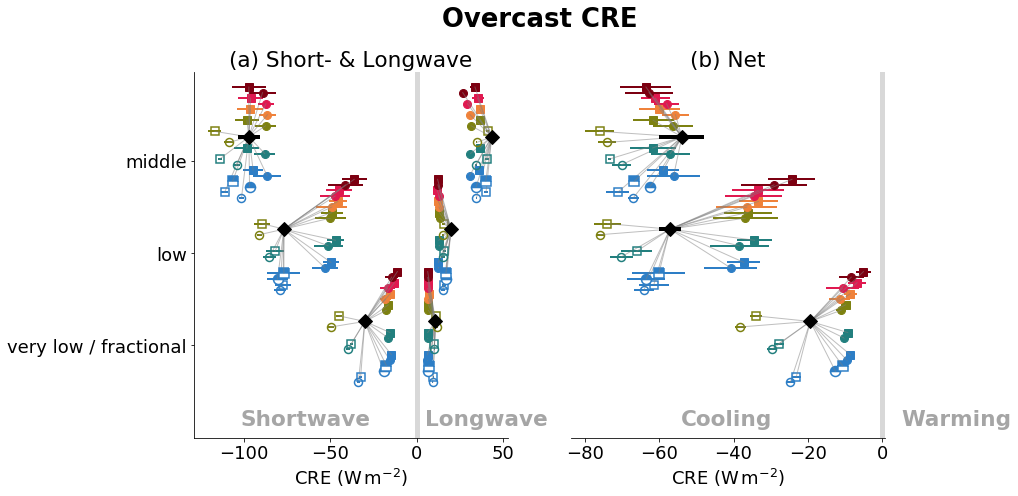

In [20]:
fig, ax = pl.subplots( ncols = 2, figsize = (24, 7), )

pl.sca(ax[0])
vert_stacked_exp_plot( mvar, 'scre_ave' , var_err = dvar, doffset =0.06)
vert_stacked_exp_plot( mvar, 'lcre_ave' , var_err = dvar, doffset =0.06)

xlim = pl.xlim()
pl.text( xlim[0] / 2, -0.8, 'Shortwave', 
            color = 'gray', ha = 'center', va = 'center', alpha = 0.7, 
            fontweight = 'bold', fontsize = 'large')

pl.text( 40, -0.8, 'Longwave', 
            color = 'gray', ha = 'center', va = 'center', alpha = 0.7, 
            fontweight = 'bold', fontsize = 'large')

sns.despine(ax = ax[0])
pl.title('(a) Short- & Longwave')


pl.sca(ax[1])
vert_stacked_exp_plot( mvar, 'net_cre_ave' , var_err = dvar, doffset =0.06)
sns.despine(left = True, ax = ax[1])
pl.title('(b) Net')
pl.yticks([])
xlim = pl.xlim()

pl.text( xlim[0] / 2, -0.8, 'Cooling', 
            color = 'gray', ha = 'center', va = 'center', alpha = 0.7, 
            fontweight = 'bold', fontsize = 'large')

pl.text( 20, -0.8, 'Warming', 
            color = 'gray', ha = 'center', va = 'center', alpha = 0.7, 
            fontweight = 'bold', fontsize = 'large')

#plegend()

for a in ax:
    a.axvline(0, color = 'gray', lw = 5, alpha = 0.3)
    a.set_xlabel('CRE ($\mathrm{W\, m^{-2}}$)')
    a.set_ylim(-1,None)

pl.suptitle('Overcast CRE', fontsize = 'x-large', fontweight = 'bold')

pl.subplots_adjust( left = 0.3, right = 0.7, top = 0.85 )
pl.savefig( '../pics/cre_overcast-vs-ct_shallowcloud-set2.png', dpi = 300,)


## Plot CRE biases

In [15]:
daily_bias = daily_mean - daily_mean.sel(idname = 'msevi-scaled')


idlist = list( daily_bias.idname.data )
idlist.remove('msevi-scaled')

daily_bias = daily_bias.sel(idname = idlist)

mbias = daily_bias.mean('day')
dbias = daily_bias.std('day')



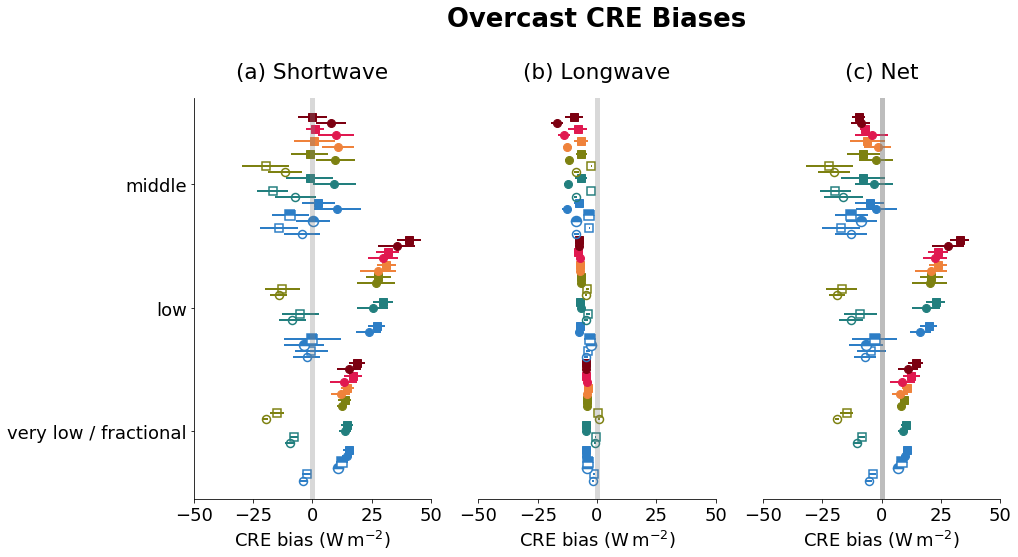

In [16]:
fig, ax = pl.subplots( ncols = 3,  figsize = (28, 8), )

pl.sca(ax[0])
vert_stacked_exp_plot( mbias, 'scre_ave' , 
                       var_err = dbias, doffset = 0.05, 
                       connect2obs = False, obsref_name = '2km_oneMom_noConv')
sns.despine(ax = ax[0])
pl.title('(a) Shortwave', pad = 20)

pl.sca(ax[1])
vert_stacked_exp_plot( mbias, 'lcre_ave' , 
                       var_err = dbias, doffset = 0.05, 
                       connect2obs = False, obsref_name = '2km_oneMom_noConv')
pl.yticks([])
pl.title('(b) Longwave', pad = 20)

pl.sca(ax[2])
vert_stacked_exp_plot( mbias, 'net_cre_ave' , 
                       var_err = dbias, doffset = 0.05, 
                       connect2obs = False, obsref_name = '2km_oneMom_noConv')
pl.yticks([])
pl.title('(c) Net', pad = 20)

pl.suptitle('Overcast CRE Biases', fontsize = 'x-large', fontweight = 'bold')
for a in ax:
    a.set_xlim(-50,50)
    a.axvline(0, color = 'gray', lw = 5, alpha = 0.3)
    a.set_xlabel('CRE bias ($\mathrm{W\, m^{-2}}$)')
    
for a in ax[1:]:
    sns.despine(left = True, ax = a)
    
pl.axvline(0, color = 'gray', lw = 5, alpha = 0.3)
pl.subplots_adjust( left = 0.3, right = 0.7, top = 0.82 )
pl.savefig( '../pics/cre-overcast_bias-vs-ct_shallowcloud_set2.png', dpi = 300,)
